<br><br><br><br><br>

# Coding Fast and Fast Code

<br><br><br><br><br>

<br>

<img src="img/commute-by-plane.png" width="65%"> _(Stolen from Jake Vanderplas.)_

<br><br><br><br><br><br>

<center><b>Extended analogy:</b> drive your car to the airport, then take an airplane.</center>

<br><br><br><br><br><br>

<br><br>

**Typical analysis workflow:**

   1. Start with small dataset; plot some things, compute some things, get a sense of the data.
   2. Collect one-liners, notebook cells, scripts into an executable.
   3. Run the executable on ever-larger datasets.
   4. Run it in different ways to quantify systematic errors.
   5. Realize that it wasn't written efficiently enough to finish analysis before deadline.
   6. Rewrite it in a faster language (e.g. Python → C++).
   7. Wonder why the new code doesn't reproduce the old results.

<br>

**The problem is step 6:** frameworks should allow you to improve in _small steps_, not _major rewrites_.

<br><br>

In [1]:
# Example problem: compute Z masses, starting in pure Python.

import uproot
import numpy
import math

arrays = uproot.open("data/Zmumu.root")["events"].arrays(["E*", "p*"], namedecode="utf-8")
for n in arrays:
    exec(f"{n} = numpy.repeat(arrays['{n}'], 1000)")
    exec(f"{n}_tiny = arrays['{n}'].tolist()")

def baseline_calculate(E1, E2, px1, px2, py1, py2, pz1, pz2):
    out = []
    for i in range(len(E1)):
        out.append(math.sqrt((E1[i] + E2[i])**2 - (px1[i] + px2[i])**2 -
                             (py1[i] + py2[i])**2 - (pz1[i] + pz2[i])**2))
    return out

masses = baseline_calculate(E1_tiny, E2_tiny, px1_tiny, px2_tiny,
                            py1_tiny, py2_tiny, pz1_tiny, pz2_tiny)
masses[0]

82.46269155513643

In [2]:
%%timeit

# All speed tests, other than this pure Python one, will use a dataset 1000 times larger.

masses = baseline_calculate(E1_tiny, E2_tiny, px1_tiny, px2_tiny, py1_tiny, py2_tiny, pz1_tiny, pz2_tiny)

1.86 ms ± 13.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [3]:
import numpy
import numexpr

# The Numpy way: compute a step for all values before moving to the next step
# Intermediate arrays have to be allocated, and this doesn't make good use of CPU cache.
def numpy_calculate(E1, E2, px1, px2, py1, py2, pz1, pz2):
    return numpy.sqrt((E1 + E2)**2 - (px1 + px2)**2 - (py1 + py2)**2 - (pz1 + pz2)**2)

# The NumExpr way: compute a whole expression for each value before moving to the next value,
# as you would in C++ code.
numexpr_calculate = numexpr.NumExpr(
    "sqrt((E1 + E2)**2 - (px1 + px2)**2 - (py1 + py2)**2 - (pz1 + pz2)**2)")

In [4]:
%%timeit

masses = numpy_calculate(E1, E2, px1, px2, py1, py2, pz1, pz2)

24.4 ms ± 221 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [5]:
%%timeit

masses = numexpr_calculate.run(E1, E2, px1, px2, py1, py2, pz1, pz2)

6.54 ms ± 16.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


For complex formulae, such as these with 8 input arrays and 12 operations, a single pass is much better than 12 passes, and NumExpr helps a lot.

| Method         | Capabilities                     | Time (ms) | Parallel? | Speedup |
|:---------------|:---------------------------------|----------:|:---------:|--------:|
| Pure Python    | dynamic for loops                | 19200     | no        |      1× |
| Numpy          | array-at-a-time                  | 449       | no        |     40× |
| NumExpr        | single-pass ufunc                |  70       | yes       |    270× |

In [6]:
# NumExpr is a very simple virtual machine, with instructions like add_ddd and sqrt_dd.

numexpr.disassemble(numexpr_calculate)

[(b'add_ddd', b'r0', b'r1[E1]', b'r2[E2]'),
 (b'mul_ddd', b'r0', b'r0', b'r0'),
 (b'add_ddd', b't9', b'r3[px1]', b'r4[px2]'),
 (b'mul_ddd', b't9', b't9', b't9'),
 (b'sub_ddd', b't9', b'r0', b't9'),
 (b'add_ddd', b'r0', b'r5[py1]', b'r6[py2]'),
 (b'mul_ddd', b't10', b'r0', b'r0'),
 (b'sub_ddd', b'r0', b't9', b't10'),
 (b'add_ddd', b't10', b'r7[pz1]', b'r8[pz2]'),
 (b'mul_ddd', b't10', b't10', b't10'),
 (b'sub_ddd', b't9', b'r0', b't10'),
 (b'sqrt_dd', b'r0', b't9', None)]

In [7]:
import formulate

# The formulate package converts ROOT's TTree::Draw expressions to and from NumExpr.

(formulate.from_root(
    "TMath::Sqrt((E1 + E2)**2 - (px1 + px2)**2 - (py1 + py2)**2 - (pz1 + pz2)**2)")
          .to_numexpr())

'sqrt((((E1 + E2) ** 2) - ((px1 + px2) ** 2) - ((py1 + py2) ** 2) - ((pz1 + pz2) ** 2)))'

<br><br><br>

<center><img src="img/numba-logo.png" width="30%"></center>

<br><br><br>

In [8]:
import numba
import math

# The Numba way: send whole functions to the LLVM compiler (same as Clang): compiled Python!
@numba.jit
def numba_calculate(E1, E2, px1, px2, py1, py2, pz1, pz2):
    out = numpy.empty(len(E1))
    for i in range(len(E1)):
        out[i] = math.sqrt(
            (E1[i] + E2[i])**2 - (px1[i] + px2[i])**2 - (py1[i] + py2[i])**2 - (pz1[i] + pz2[i])**2)
    return out

masses = numba_calculate(E1, E2, px1, px2, py1, py2, pz1, pz2)
masses

array([82.46269156, 82.46269156, 82.46269156, ..., 96.65672765,
       96.65672765, 96.65672765])

In [9]:
%%timeit

masses = numba_calculate(E1, E2, px1, px2, py1, py2, pz1, pz2)

7.43 ms ± 79.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


The Numba code is the same as the pure Python, and has much of the same flexibility, yet is 160× faster.

<br>

| Method         | Capabilities                     | Time (ms) | Parallel? | Speedup |
|:---------------|:---------------------------------|----------:|:---------:|--------:|
| Pure Python    | dynamic for loops                | 19200     | no        |      1× |
| Numpy          | array-at-a-time                  | 449       | no        |     40× |
| NumExpr        | single-pass ufunc                |  70       | yes       |    270× |
| Numba          | numerical for loops              | 121       | no        |    160× |

<br>

**This is a good way to gradually optimize Python code: wrap numerically intensive sections with numba.jit.**

In [10]:
# High-performance tricks:
# 
#     range → prange is like OpenMP's parallel for (enabled by parallel=True)
#     fastmath sacrfices accuracy for speed in transcendental functions

@numba.jit(parallel=True, fastmath=True)
def numba_calculate2(E1, E2, px1, px2, py1, py2, pz1, pz2):
    out = numpy.empty(len(E1))
    for i in numba.prange(len(E1)):    # prange, not range
        out[i] = math.sqrt(
            (E1[i] + E2[i])**2 - (px1[i] + px2[i])**2 - (py1[i] + py2[i])**2 - (pz1[i] + pz2[i])**2)
    return out

masses = numba_calculate2(E1, E2, px1, px2, py1, py2, pz1, pz2)
masses

array([82.46269156, 82.46269156, 82.46269156, ..., 96.65672765,
       96.65672765, 96.65672765])

In [11]:
%%timeit

masses = numba_calculate2(E1, E2, px1, px2, py1, py2, pz1, pz2)

8.42 ms ± 128 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Now Numba is playing most of the same tricks as NumExpr and gains the same advantage. But you get more flexibility with Numba (beyond a single for loop).

| Method         | Capabilities                     | Time (ms) | Parallel? | Speedup |
|:---------------|:---------------------------------|----------:|:---------:|--------:|
| Pure Python    | dynamic for loops                | 19200     | no        |      1× |
| Numpy          | array-at-a-time                  | 449       | no        |     40× |
| NumExpr        | single-pass ufunc                |  70       | yes       |    270× |
| Numba          | numerical for loops              | 121       | no        |    160× |
| Numba + tricks | numerical for loops              |  82.6     | yes       |    230× |

In [12]:
# We can make our own ufuncs:
# 
#     define f(A[i], B[i]) → C[i] to get f(A, B) → C

@numba.vectorize
def numba_calculate_ufunc(E1, E2, px1, px2, py1, py2, pz1, pz2):
    return math.sqrt((E1 + E2)**2 - (px1 + px2)**2 - (py1 + py2)**2 - (pz1 + pz2)**2)

masses = numba_calculate_ufunc(E1, E2, px1, px2, py1, py2, pz1, pz2)
masses

array([82.46269156, 82.46269156, 82.46269156, ..., 96.65672765,
       96.65672765, 96.65672765])

In [13]:
%%timeit

masses = numba_calculate_ufunc(E1, E2, px1, px2, py1, py2, pz1, pz2)

7.45 ms ± 49 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


`numba.vectorize` is a convenience wrapper; we get back the same speed as a non-tricky `numba.jit`.

| Method         | Capabilities                     | Time (ms) | Parallel? | Speedup |
|:---------------|:---------------------------------|----------:|:---------:|--------:|
| Pure Python    | dynamic for loops                | 19200     | no        |      1× |
| Numpy          | array-at-a-time                  | 449       | no        |     40× |
| NumExpr        | single-pass ufunc                |  70       | yes       |    270× |
| **Numba**      | **numerical for loops**          | **121**   | **no**    | **160×** |
| Numba + tricks | numerical for loops              |  82.6     | yes       |    230× |

In [14]:
# And we can compile Python code that runs on a GPU!
import numba.cuda

@numba.cuda.jit
def numba_calculate_cuda(E1, E2, px1, px2, py1, py2, pz1, pz2, out):
    i = numba.cuda.grid(1)
    if i < len(out):
        out[i] = math.sqrt(
            (E1[i] + E2[i])**2 - (px1[i] + px2[i])**2 - (py1[i] + py2[i])**2 - (pz1[i] + pz2[i])**2)

# Although you have to set up some GPU details...
out_gpu = numba.cuda.device_array(len(E1), dtype=numpy.float64)
for n in "E1", "E2", "px1", "px2", "py1", "py2", "pz1", "pz2":
    exec(f"{n}_gpu = numba.cuda.to_device({n})")

griddim = math.ceil(len(E1) / 1024)
blockdim = 1024
numba_calculate_cuda[griddim, blockdim](
    E1_gpu, E2_gpu, px1_gpu, px2_gpu, py1_gpu, py2_gpu, pz1_gpu, pz2_gpu, out_gpu)

out_gpu.copy_to_host()

array([82.46269156, 82.46269156, 82.46269156, ..., 96.65672765,
       96.65672765, 96.65672765])

In [15]:
%%timeit

numba_calculate_cuda[griddim, blockdim](
    E1_gpu, E2_gpu, px1_gpu, px2_gpu, py1_gpu, py2_gpu, pz1_gpu, pz2_gpu, out_gpu)

1.02 ms ± 90.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In all the code samples I've tested, Numba's CUDA performance is consistently amazing.

| Method         | Capabilities                     | Time (ms) | Parallel? | Speedup |
|:---------------|:---------------------------------|----------:|:---------:|--------:|
| Pure Python    | dynamic for loops                | 19200     | no        |      1× |
| Numpy          | array-at-a-time                  | 449       | no        |     40× |
| NumExpr        | single-pass ufunc                |  70       | yes       |    270× |
| Numba          | numerical for loops              | 121       | no        |    160× |
| Numba + tricks | numerical for loops              |  82.6     | yes       |    230× |
| Numba + CUDA   | numerical for loops              |  10.7     | (GPU)     |   1800× |

<br><br><br>

<center><img src="img/cupy-logo.png" width="25%"></center>

<br><br><br>

In [16]:
import cupy

for n in "E1", "E2", "px1", "px2", "py1", "py2", "pz1", "pz2":
    exec(f"{n}_gpu = cupy.array({n})")

# The CuPy way: just like Numpy, but on the GPU
def cupy_calculate(E1, E2, px1, px2, py1, py2, pz1, pz2):
    return cupy.sqrt((E1 + E2)**2 - (px1 + px2)**2 - (py1 + py2)**2 - (pz1 + pz2)**2)

masses = cupy_calculate(E1_gpu, E2_gpu, px1_gpu, px2_gpu, py1_gpu, py2_gpu, pz1_gpu, pz2_gpu)
masses

array([82.46269156, 82.46269156, 82.46269156, ..., 96.65672765,
       96.65672765, 96.65672765])

In [17]:
%%timeit

masses = cupy_calculate(E1_gpu, E2_gpu, px1_gpu, px2_gpu, py1_gpu, py2_gpu, pz1_gpu, pz2_gpu)

13.4 ms ± 32.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Even though it's running on the GPU, CuPy works like Numpy, allocating intermediate arrays.

It's better than Numpy on the CPU, and easier to set up than Numba-CUDA.

| Method         | Capabilities                     | Time (ms) | Parallel? | Speedup |
|:---------------|:---------------------------------|----------:|:---------:|--------:|
| Pure Python    | dynamic for loops                | 19200     | no        |      1× |
| Numpy          | array-at-a-time                  | 449       | no        |     40× |
| NumExpr        | single-pass ufunc                |  70       | yes       |    270× |
| Numba          | numerical for loops              | 121       | no        |    160× |
| Numba + tricks | numerical for loops              |  82.6     | yes       |    230× |
| Numba + CUDA   | numerical for loops              |  10.7     | (GPU)     |   1800× |
| CuPy           | array-at-a-time                  | 139       | (GPU)     |    140× |

<br><br><br>

<center><img src="img/dask-logo.png" width="25%"></center>

<br><br><br>

In [18]:
# The Dask way: accumulate a graph of steps in the calculation to parallelize (possibly remote)

import dask.array

for n in "E1", "E2", "px1", "px2", "py1", "py2", "pz1", "pz2":
    exec(f"{n}_dask = dask.array.from_array({n}, chunks=len(E1)/12)")

def dask_calculate(E1, E2, px1, px2, py1, py2, pz1, pz2):
    return numpy.sqrt((E1 + E2)**2 - (px1 + px2)**2 - (py1 + py2)**2 - (pz1 + pz2)**2)

masses = dask_calculate(E1_dask, E2_dask, px1_dask, px2_dask, py1_dask, py2_dask, pz1_dask, pz2_dask)
masses

dask.array<sqrt, shape=(2304000,), dtype=float64, chunksize=(192000,)>

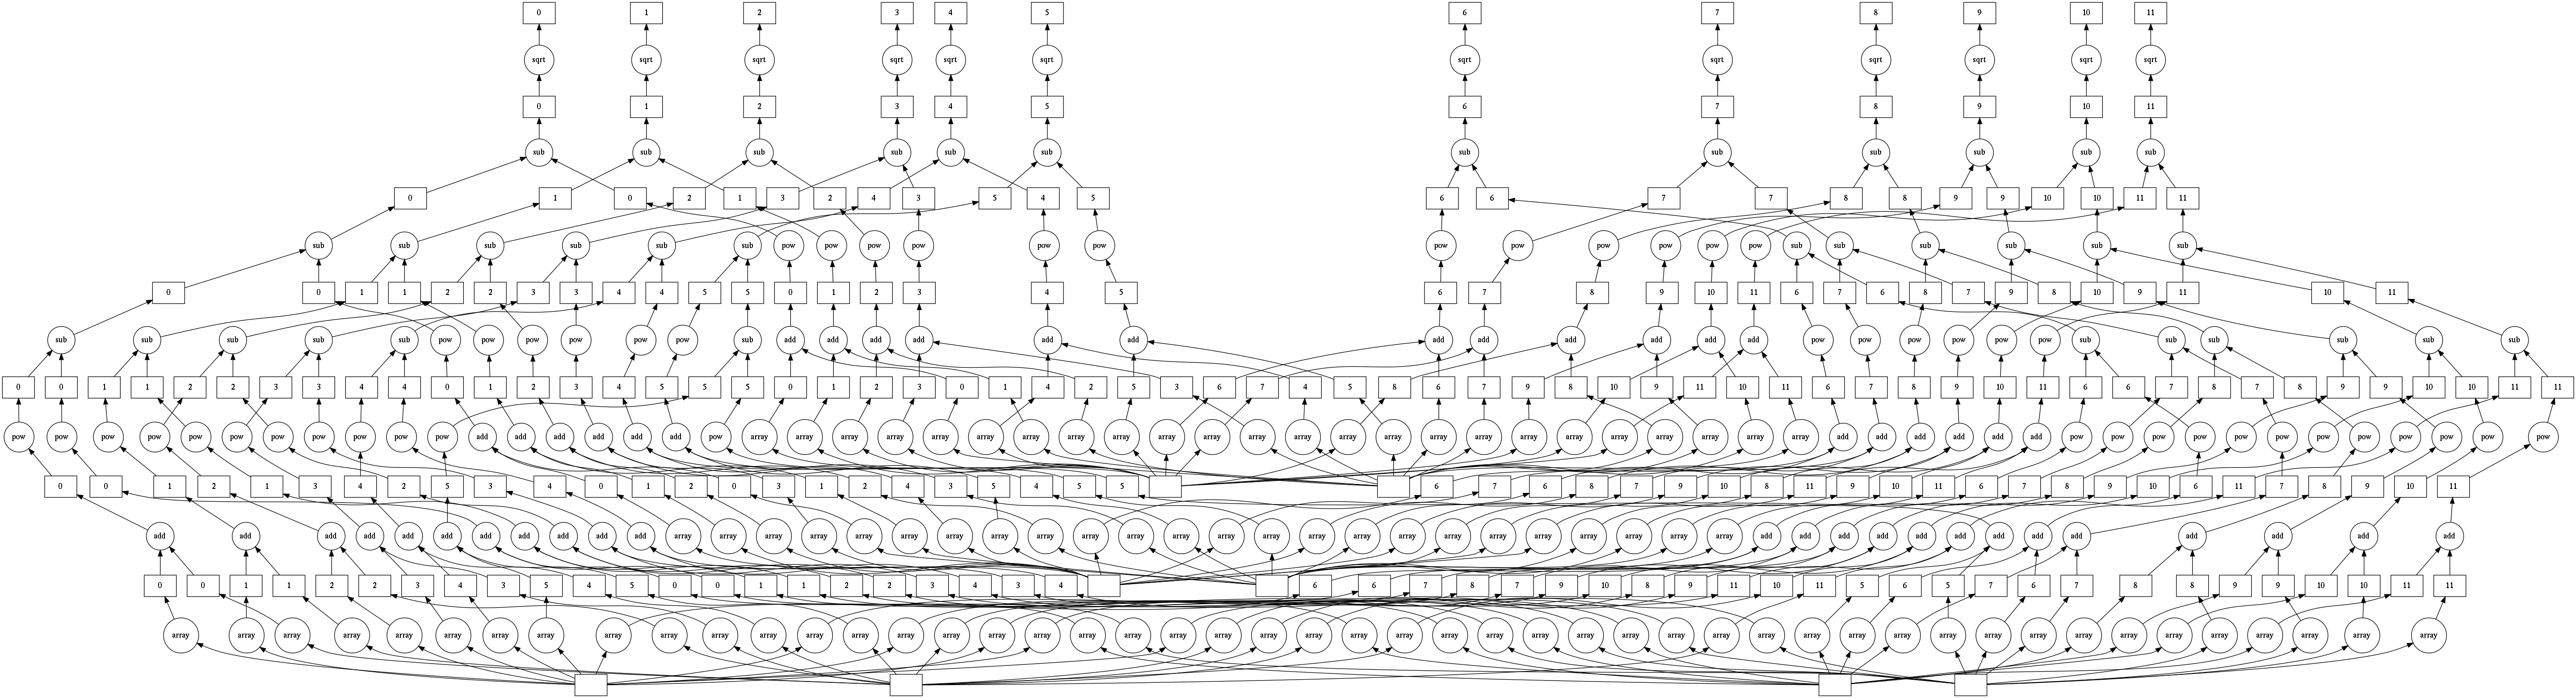

In [19]:
masses.visualize()

In [20]:
%%timeit

masses.compute()

39.8 ms ± 288 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


For most examples I've tried, Dask is too fine-grained to be useful.

It spends more time coordinating tasks than crunching numbers.

| Method         | Capabilities                     | Time (ms) | Parallel? | Speedup |
|:---------------|:---------------------------------|----------:|:---------:|--------:|
| Pure Python    | dynamic for loops                | 19200     | no        |      1× |
| Numpy          | array-at-a-time                  | 449       | no        |     40× |
| NumExpr        | single-pass ufunc                |  70       | yes       |    270× |
| Numba          | numerical for loops              | 121       | no        |    160× |
| Numba + tricks | numerical for loops              |  82.6     | yes       |    230× |
| Numba + CUDA   | numerical for loops              |  10.7     | (GPU)     |   1800× |
| CuPy           | array-at-a-time                  | 139       | (GPU)     |    140× |
| Dask           | array-at-a-time as tasks         | 395       | yes       |     50× |

<br>

However, it's an easy way to scale _out_ to a remote cluster. If all the real work is done inside a single node (a ufunc created by `numba.vectorize`), then it could be worthwhile.

<br><br><br>

<center><img src="img/cython-logo.png" width="25%"></center>

<br><br><br>

In [21]:
%load_ext Cython

# Cython is a language that mixes C++ and Python. Can it help?

In [22]:
%%cython --cplus -c-O3 -a
import cython, numpy
cimport numpy
from libc.math cimport sqrt

@cython.boundscheck(False)    # don't check for out-of-bounds array errors
@cython.wraparound(False)     # don't convert negative indexes to wrap-around (e.g. -1 is last item)
def cython_calculate(E1, E2, px1, px2, py1, py2, pz1, pz2):
    out = numpy.empty(len(E1))
    cdef numpy.ndarray[numpy.float64_t, ndim=1, mode="c"] out_raw = out    # boilerplate!
    cdef numpy.ndarray[numpy.float64_t, ndim=1, mode="c"] E1_raw = E1
    cdef numpy.ndarray[numpy.float64_t, ndim=1, mode="c"] E2_raw = E2
    cdef numpy.ndarray[numpy.float64_t, ndim=1, mode="c"] px1_raw = px1
    cdef numpy.ndarray[numpy.float64_t, ndim=1, mode="c"] px2_raw = px2
    cdef numpy.ndarray[numpy.float64_t, ndim=1, mode="c"] py1_raw = py1
    cdef numpy.ndarray[numpy.float64_t, ndim=1, mode="c"] py2_raw = py2
    cdef numpy.ndarray[numpy.float64_t, ndim=1, mode="c"] pz1_raw = pz1
    cdef numpy.ndarray[numpy.float64_t, ndim=1, mode="c"] pz2_raw = pz2
    cdef int length = len(E1)
    for i in range(length):
        out_raw[i] = sqrt((E1_raw[i] + E2_raw[i])**2 - (px1_raw[i] + px2_raw[i])**2 -
                          (py1_raw[i] + py2_raw[i])**2 - (pz1_raw[i] + pz2_raw[i])**2)
    return out

In [23]:
%%timeit

masses = cython_calculate(E1, E2, px1, px2, py1, py2, pz1, pz2)

8.93 ms ± 123 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Cython is a lot of extra work (manually converting Python objects to C++ objects) to get the same speedup as `numba.jit`.

| Method         | Capabilities                     | Time (ms) | Parallel? | Speedup |
|:---------------|:---------------------------------|----------:|:---------:|--------:|
| Pure Python    | dynamic for loops                | 19200     | no        |      1× |
| Numpy          | array-at-a-time                  | 449       | no        |     40× |
| NumExpr        | single-pass ufunc                |  70       | yes       |    270× |
| Numba          | numerical for loops              | 121       | no        |    160× |
| Numba + tricks | numerical for loops              |  82.6     | yes       |    230× |
| Numba + CUDA   | numerical for loops              |  10.7     | (GPU)     |   1800× |
| CuPy           | array-at-a-time                  | 139       | (GPU)     |    140× |
| Dask           | array-at-a-time as tasks         | 395       | yes       |     50× |
| Cython         | numerical for loops (hybrid C++) | 137       | no        |    140× |

<br><br><br>

<center><img src="img/pybind11-logo.png" width="40%"></center>

<br><br><br>

In [24]:
%%writefile cpp_calculate.cpp
#include <cmath>
#include <pybind11/pybind11.h>
#include <pybind11/numpy.h>
namespace py = pybind11;
double sqr(double x) { return x*x; }
void calculate(
  py::array_t<double> E1, py::array_t<double> E2, py::array_t<double> px1, py::array_t<double> px2,
  py::array_t<double> py1, py::array_t<double> py2, py::array_t<double> pz1, py::array_t<double> pz2,
  py::array_t<double> out) {
    py::buffer_info E1_info = E1.request();
    size_t length = E1_info.size;
    auto E1_raw = static_cast<double*>(E1.request().ptr);     //# again with the boilerplate!
    auto E2_raw = static_cast<double*>(E2.request().ptr);
    auto px1_raw = static_cast<double*>(px1.request().ptr);
    auto px2_raw = static_cast<double*>(px2.request().ptr);
    auto py1_raw = static_cast<double*>(py1.request().ptr);
    auto py2_raw = static_cast<double*>(py2.request().ptr);
    auto pz1_raw = static_cast<double*>(pz1.request().ptr);
    auto pz2_raw = static_cast<double*>(pz2.request().ptr);
    auto out_raw = static_cast<double*>(out.request().ptr);
    for (size_t i = 0;  i < length;  i++) {
        out_raw[i] = sqrt(sqr(E1_raw[i] + E2_raw[i]) - sqr(px1_raw[i] + px2_raw[i]) -
                          sqr(py1_raw[i] + py2_raw[i]) - sqr(pz1_raw[i] + pz2_raw[i]));
    }
}
PYBIND11_MODULE(cpp_calculate, m) {
    m.def("calculate", &calculate, "");
}

Writing cpp_calculate.cpp


In [25]:
%%bash

# Compile it as a Python extension module

c++ -Wall -shared -std=c++11 -fPIC -O3 -ffast-math \
    `python -m pybind11 --includes` cpp_calculate.cpp \
    -o cpp_calculate`python3-config --extension-suffix`

In [26]:
import cpp_calculate

masses = numpy.empty(len(E1), dtype=numpy.float64)
cpp_calculate.calculate(E1, E2, px1, px2, py1, py2, pz1, pz2, masses)
masses

array([82.46269156, 82.46269156, 82.46269156, ..., 96.65672765,
       96.65672765, 96.65672765])

In [27]:
%%timeit

cpp_calculate.calculate(E1, E2, px1, px2, py1, py2, pz1, pz2, masses)

17.8 ms ± 127 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Not as good as Numba and Cython, but I may be overlooking something (compiled with `-O3 -ffast-math`).

| Method         | Capabilities                     | Time (ms) | Parallel? | Speedup |
|:---------------|:---------------------------------|----------:|:---------:|--------:|
| Pure Python    | dynamic for loops                | 19200     | no        |      1× |
| Numpy          | array-at-a-time                  | 449       | no        |     40× |
| NumExpr        | single-pass ufunc                |  70       | yes       |    270× |
| Numba          | numerical for loops              | 121       | no        |    160× |
| Numba + tricks | numerical for loops              |  82.6     | yes       |    230× |
| Numba + CUDA   | numerical for loops              |  10.7     | (GPU)     |   1800× |
| CuPy           | array-at-a-time                  | 139       | (GPU)     |    140× |
| Dask           | array-at-a-time as tasks         | 395       | yes       |     50× |
| Cython         | numerical for loops (hybrid C++) | 137       | no        |    140× |
| pybind11       | numerical for loops (pure C++)   | 208       | no        |     90× |

<br><br><br>

<center><img src="img/root-logo.png" width="40%"></center>

<br><br><br>

In [28]:
import ROOT

# With ROOT, it's much easier to mingle C++ in Python

ROOT.gInterpreter.Declare("""
double sqr(double x) { return x*x; }

void root_calculate(int length, double* E1, double* E2, double* px1, double* px2,
                    double* py1, double* py2, double* pz1, double* pz2, double* out) {
    for (int i = 0;  i < length;  i++) {
        out[i] = sqrt(sqr(E1[i] + E2[i]) - sqr(px1[i] + px2[i]) -
                      sqr(py1[i] + py2[i]) - sqr(pz1[i] + pz2[i]));
    }
}
""")

# Numpy arrays are automatically converted into C++ arrays
masses = numpy.empty(len(E1), dtype=numpy.float64)
ROOT.root_calculate(len(E1), E1, E2, px1, px2, py1, py2, pz1, pz2, masses)
masses

Welcome to JupyROOT 6.17/01


array([82.46269156, 82.46269156, 82.46269156, ..., 96.65672765,
       96.65672765, 96.65672765])

In [29]:
%%timeit

# ROOT.gInterpreter compiles declarations at minimal optimization level (-O0)
# because it's intended to be used as a commandline: not for the highly optimized code.

ROOT.root_calculate(len(E1), E1, E2, px1, px2, py1, py2, pz1, pz2, masses)

25.1 ms ± 1.74 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


ROOT is certainly the easiest way to mix C++ and Python code, but it's not compiling with all optimizations.

| Method         | Capabilities                     | Time (ms) | Parallel? | Speedup |
|:---------------|:---------------------------------|----------:|:---------:|--------:|
| Pure Python    | dynamic for loops                | 19200     | no        |      1× |
| Numpy          | array-at-a-time                  | 449       | no        |     40× |
| NumExpr        | single-pass ufunc                |  70       | yes       |    270× |
| Numba          | numerical for loops              | 121       | no        |    160× |
| Numba + tricks | numerical for loops              |  82.6     | yes       |    230× |
| Numba + CUDA   | numerical for loops              |  10.7     | (GPU)     |   1800× |
| CuPy           | array-at-a-time                  | 139       | (GPU)     |    140× |
| Dask           | array-at-a-time as tasks         | 395       | yes       |     50× |
| Cython         | numerical for loops (hybrid C++) | 137       | no        |    140× |
| pybind11       | numerical for loops (pure C++)   | 208       | no        |     90× |
| ROOT (`-O0`)   | numerical for loops (pure C++)   | 317       | no        |     60× |

**Bottom line:** NumExpr for the simple stuff, Numba for more than a single for loop, pybind11 or ROOT if you're _linking_ to precompiled, highly optimized code.